# Exploratory Data Analysis
---

In this notebook I will perform a exploratory data analysis on the API data I just acquired from previous notebook. This will include setting the threshold to filter out the unwanted games by looking at the distribution of my review data.

Then I will clean out any game name, context, and features that consist language other than English. Followed by performing exploring variance of the features and interpret the features each by each.

Lastly, cleaning out the game descriptions that has html and CSS format, then perform tfidf and explore the word count weights in the game description. Combine all data that performed EDA on and move to the next step. 



### Table of Contents:

1. [EDA: Data Cleaning (game_reviews)](#EDA:-Data-Cleaning-(game_reviews))
    1. [Review Counts Filtering](#Review-Counts-Filtering)
    2. [Positive Review Rates Filtering](#Positive-Review-Rates-Filtering)
2. [EDA: Data Cleaning (game_lookup)](#EDA:-Data-Cleaning-(game_lookup))
3. [EDA: Data Cleaning (game_features)](#EDA:-Data-Cleaning-(game_features))
    1. [Filter by variance](#Filter-by-Variance)
    2. [Manual Interpretation](#Manual-Interpretation-on-Features)
4. [EDA: Data Cleaning (game_description)](#EDA:-Data-Cleaning-(game_description))
--- 

### Import Libraries


In [1]:
import pandas as pd
import numpy as np
import time
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse
import scipy.stats as stats
import pylab as pl
import re

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
sns.set_palette(palette='colorblind')
%matplotlib inline

## Import DataFrame 

In [5]:
game_features = pd.read_csv('./datas/game_features_1.csv', index_col=[0])
game_features.rename_axis(['game_id'], inplace=True)

In [8]:
game_description = pd.read_csv('./datas/game_description_1.csv', index_col=[0])
game_description.rename_axis(['game_id'], inplace=True)

In [9]:
game_lookup = pd.read_csv('./datas/top_df.csv', index_col='game_id')

In [10]:
game_reviews = pd.read_csv('./datas/game_review_1.csv', index_col='game_id')

# EDA: Data Cleaning (game_reviews)
---

I will drop duplicate index. This might occur from API scrapping and merging. Therefore, this is to prevent any duplicate data.

In [12]:
game_reviews = game_reviews[~game_reviews.index.duplicated(keep=False)]

In [13]:
game_reviews.shape

(30631, 2)

I will create a new columns that calculate the positive review rate of that specific game. This will be used to create a threshold to filter some of the unwanted games in my library.

In [14]:
game_reviews['positive_rate'] = game_reviews['positive_reviews'] / game_reviews['total_reviews']

## Review Counts Filtering

As the graph shown below, this demonstrate that we have a outlier that has review count of almost 700,000. Alot of the review counts are falling between 0 to 100,000. I will temperay remove this and draw an distribution graph to set a threshold of how many reviews are considered a good amout in my data set.

I will create a boolean that filters out any reviews from 1 to 10; the reason why I do this is because based on the graph below around 2,250 games falls within 0 to 1 reviews. 

In [15]:
game_test = game_reviews['total_reviews'][(game_reviews['total_reviews'] <= 10) & (game_reviews['total_reviews'] >= 1)]
print(f'Game reviews within 1 to 10 covers around '+str(round(len(game_test) / len(game_reviews['total_reviews']) * 100,2))+'% of my dataset.')

Game reviews within 1 to 10 covers around 35.14% of my dataset.


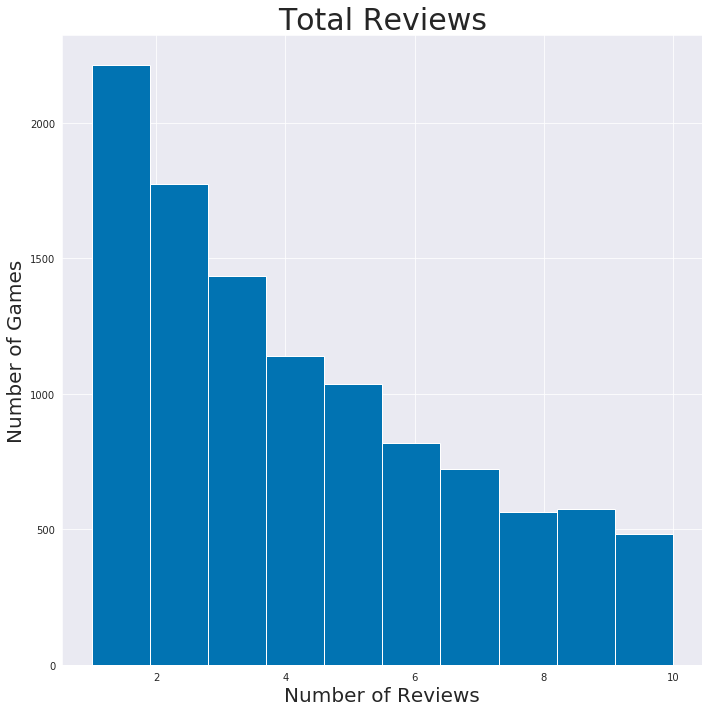

In [16]:
plt.figure(figsize=(10,10))
plt.hist(game_test, bins=10)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.ylabel(f'Number of Games', fontsize=20)
plt.xlabel(f'Number of Reviews', fontsize=20)
plt.title(f'Total Reviews', fontsize=30)
plt.tight_layout();

Based on the graph above; I will eliminate the game that has review counts lower than 10. This will eliminate around 35.14% of games. Because not every user will write reviews on the game they purchased. So the count will be lower than the actual game purchased. Unfortunately it is impossible to acquire the game purchased count from Steam API. 

In [17]:
review_under10 = game_reviews.index[game_reviews['total_reviews'] < 10]

In [18]:
game_reviews.drop(review_under10, axis=0, inplace=True)

In [19]:
game_reviews.shape

(13272, 3)

## Positive Review Rates Filtering

After the review filtering; I have total of 13,272 games in my game library that has more than 10 reviews. Then we will move into the next filtering process. Filter by the positive review rates. 

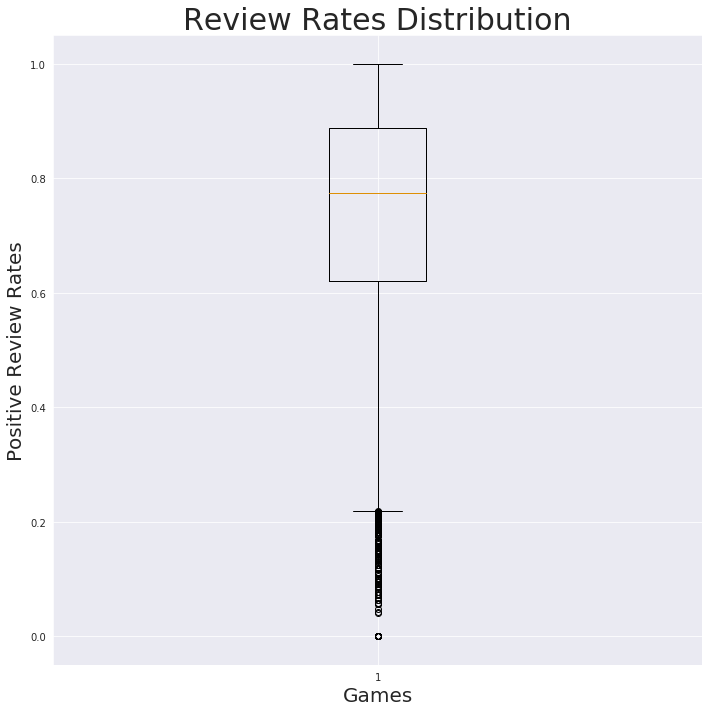

In [20]:
plt.figure(figsize=(10,10))
plt.boxplot(game_reviews['positive_rate'])
plt.yticks(fontsize=10)
plt.xlabel(f'Games', fontsize=20)
plt.ylabel(f'Positive Review Rates', fontsize=20)
plt.xticks(fontsize=10)
plt.title(f'Review Rates Distribution', fontsize=30)
plt.tight_layout();

According to the box-plot above, we can noticed that our mean review rates are around 0.8. This is good, this means that most of our game has good positive review; meaning it's a good game that I want to recommend to users. There are several games that has rates of lower than 0.2 and beyond. 0.5 looks like a rates that can remove the games that are lack for positive review.

I will eliminate games that has review rates of 0.5 and lower. This will remove additional 1,715 games from the review counts filter process. 

In [21]:
low_rate = game_reviews.index[game_reviews['positive_rate'] < 0.5]
len(low_rate)

1715

In [22]:
game_reviews.drop(low_rate, axis=0, inplace=True)

After performing the EDA on game reviews, we started with 30,631 games to 11,557 games. These are the games that has good review counts and high positive review rates. 

In [23]:
game_reviews.head()

,positive_reviews,total_reviews,positive_rate
game_id,,,
939360,10,12,0.833333
939400,36,41,0.878049
939450,10,10,1.000000
939000,52,59,0.881356
939180,11,17,0.647059


In [24]:
game_reviews.shape

(11557, 3)

# EDA: Data Cleaning (game_lookup)
---

I will merge my game_reviews DataFrame and game_lookup together. This is to match up the game_id. Reason why is because after the filtering process from game_reviews, that eliminate a lot of games. To further filtering I will need to match the game_id on each DataFrame.  

This game_lookup perform like my "game library" on my recommender system. 

In [25]:
game_lookup.drop('Unnamed: 0', axis=1, inplace=True)

In [26]:
game_lookup = pd.merge(game_lookup, game_reviews[['positive_rate']], left_index=True, right_index=True)

I will drop duplicate index. This might occur from API scrapping and merging. Therefore, this is to prevent any duplicate data.

In [27]:
game_lookup = game_lookup[~game_lookup.index.duplicated(keep=False)]

This matched with the game_reviews.

In [28]:
game_lookup.shape

(11557, 2)

#### Some of my game title are in none-English format. I will remove anything that's not in English

I will use a Regex to filter out the game names in English. Because I noticed some of the games are in foreign language. This will affect the result on my search function.

In [29]:
game_lookup['title'] = [re.sub("[^A-Za-z0-9.:']",  " ", str(text)) for text in game_lookup['title']]

In [30]:
game_lookup.shape

(11557, 2)

In [31]:
game_lookup.head()

,title,positive_rate
game_id,,
939360,Pixel FX Designer,0.833333
939400,LoveChoice,0.878049
939450,Forklift Simulator 2019,1.000000
939000,Crisis VRigade,0.881356
939180,Hentai Legends,0.647059


In [32]:
game_lookup.to_csv('./datas/game_lookup.csv')

# EDA: Data Cleaning (game_features)
---

I will merge my game_lookup dataframe and game_features together. This is to match up the game_id. Reason why is because after the filtering process from game_reviews and game_lookup, that eliminate a lot of games. To further filtering I will need to match the game_id on each dataframe.  


In [33]:
game_features = pd.merge(game_features, game_lookup[['title']], left_index=True, right_index=True)
game_features.drop('title', axis=1, inplace=True)

In [34]:
game_features = game_features[~game_features.index.duplicated(keep=False)]

In [35]:
game_features.shape

(11557, 86)

I will fill 0 with all the NaNs. 0 here means this specific features (like Action, Adventure.. etc) wasn't mentioned in this game. In other words, thie game does not contain this feature. 

In [36]:
 game_features.fillna(0, inplace=True)
game_features.head()

,Accounting,Action,Adventure,Animation & Modeling,Audio Production,Captions available,Casual,Co-op,Commentary available,Cross-Platform Multiplayer,...,Экшены,Включает редактор уровней,Имеется античит Valve,Контроллер (полностью),Мастерская Steam,Покупки внутри приложения,Mods,Mods (require HL2),Контроллер (частично),Приключенческие игры
game_id,,,,,,,,,,,,,,,,,,,,,
10,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Chcking the features I acquired from Web API are resonable to move on. I will do a EDA and drop out some non-important features that mentioned below.

In [37]:
game_features.columns

Index(['Accounting', 'Action', 'Adventure', 'Animation & Modeling',
       'Audio Production', 'Captions available', 'Casual', 'Co-op',
       'Commentary available', 'Cross-Platform Multiplayer',
       'Design & Illustration', 'Early Access', 'Education', 'Free to Play',
       'Full controller support', 'Game Development', 'Gore',
       'In-App Purchases', 'Includes level editor', 'Indie', 'Local Co-op',
       'Local Multi-Player', 'MMO', 'Massively Multiplayer', 'Multi-player',
       'Nudity', 'Online Co-op', 'Online Multi-Player',
       'Partial Controller Support', 'Photo Editing', 'RPG', 'Racing',
       'Sexual Content', 'Shared/Split Screen', 'Simulation', 'Single-player',
       'Software Training', 'Sports', 'Stats', 'Steam Achievements',
       'Steam Cloud', 'Steam Leaderboards', 'Steam Trading Cards',
       'Steam Workshop', 'Steam 成就', 'Steam 排行榜', 'Steam 雲端',
       'SteamVR Collectibles', 'Strategy', 'Utilities', 'Video Production',
       'Violent', '冒險', '動作', '

First I will replace any features that is not in plain English words to 'steam' and then drop them. If I kept the foreign features, it will affect my result. Some foreign words are redundent to the English features as well. (i.e 動作 means Action) 

In [38]:
game_features.columns = [re.sub('[^A-Za-z-/ ]', 'steam', str(text)) for text in game_features.columns]

A lot of the features were Steam specific. Steam achievement...etc. These is a Steam excludsive features, which has nothing to do with the game itself. Because almost every game own by steam falls into steam category. Therefore; I will be removing any features that contain 'steam' on the first 5 letters.

In [39]:
cols = [c for c in game_features.columns if c.lower()[:5] == 'steam']
game_features.drop(cols, axis=1, inplace=True)

In [40]:
game_features.columns

Index(['Accounting', 'Action', 'Adventure', 'Animation steam Modeling',
       'Audio Production', 'Captions available', 'Casual', 'Co-op',
       'Commentary available', 'Cross-Platform Multiplayer',
       'Design steam Illustration', 'Early Access', 'Education',
       'Free to Play', 'Full controller support', 'Game Development', 'Gore',
       'In-App Purchases', 'Includes level editor', 'Indie', 'Local Co-op',
       'Local Multi-Player', 'MMO', 'Massively Multiplayer', 'Multi-player',
       'Nudity', 'Online Co-op', 'Online Multi-Player',
       'Partial Controller Support', 'Photo Editing', 'RPG', 'Racing',
       'Sexual Content', 'Shared/Split Screen', 'Simulation', 'Single-player',
       'Software Training', 'Sports', 'Stats', 'Strategy', 'Utilities',
       'Video Production', 'Violent', 'Documentary', 'Includes Source SDK',
       'Tutorial', 'Web Publishing', 'VR Support', 'Valve Anti-Cheat enabled',
       'Mods', 'Mods steamrequire HLsteamsteam'],
      dtype='object'

I will drop the rows that are full of NaNs, this means that the games that were dropped was in different language.

In [41]:
game_features.dropna(axis=0, how='all',inplace=True)

In [42]:
game_features.shape

(11557, 51)

From the Bar graph below; we can deduced that around 2,500 games in my data has 4 features. followed by 5 and then 3. From this graph; I could combine some of the duplicated/similar features.

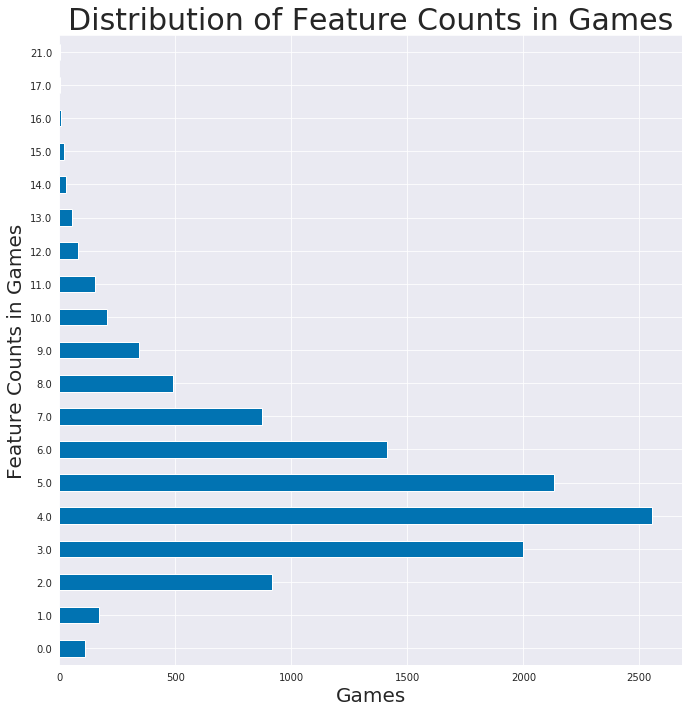

In [52]:
plt.figure(figsize=(10,10))
plt.title(f'Distribution of Feature Counts in Games', fontsize=30)
game_features.sum(1).value_counts().sort_index().plot(kind='barh')
plt.xlabel(f'Games', fontsize=20)
plt.ylabel(f'Feature Counts in Games', fontsize=20)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.tight_layout();


In [45]:
game_features.fillna(0, inplace=True)

I will be removing the lowest variance features. The reason why I remove this is because as you can see starting from Includes Source SDK the variance dropped dramatically, Therefore I set a threshold anything below 0.01 will be dropped. Since the variance is so low it's not significant enough to be our features.

In [46]:
game_features.var().sort_values(ascending=True).head(18)

Accounting                        0.000000
Tutorial                          0.000000
Documentary                       0.000000
Mods steamrequire HLsteamsteam    0.000087
Mods                              0.000173
Game Development                  0.000692
Photo Editing                     0.001641
Web Publishing                    0.001900
Software Training                 0.001900
Includes Source SDK               0.001986
Audio Production                  0.002503
Education                         0.002761
Video Production                  0.003707
Animation steam Modeling          0.005935
Commentary available              0.007046
Design steam Illustration         0.007642
Valve Anti-Cheat enabled          0.008238
Utilities                         0.009174
dtype: float64

A lot of my games mentioned Action, Adventure and Indie. These three features are going to be very important 

In [47]:
game_features.var().sort_values(ascending=False).head(20)

Action                        0.246595
Adventure                     0.234420
Indie                         0.227130
Full controller support       0.198250
Casual                        0.197697
Strategy                      0.160822
Multi-player                  0.156162
Simulation                    0.150840
RPG                           0.148041
Partial Controller Support    0.140615
Online Multi-Player           0.089197
Shared/Split Screen           0.081756
Co-op                         0.079976
Stats                         0.077685
Early Access                  0.074364
Single-player                 0.070792
Includes level editor         0.052162
Cross-Platform Multiplayer    0.050387
Local Multi-Player            0.050078
Online Co-op                  0.047516
dtype: float64

I set a threshold that if the variance has 0.01 or lower will be dropped.

In [53]:
var = game_features.columns[game_features.var() < 0.01]

In [54]:
features_vars = []
for i in game_features.var().sort_values(ascending=True).head(18):
    features_vars.append(i)

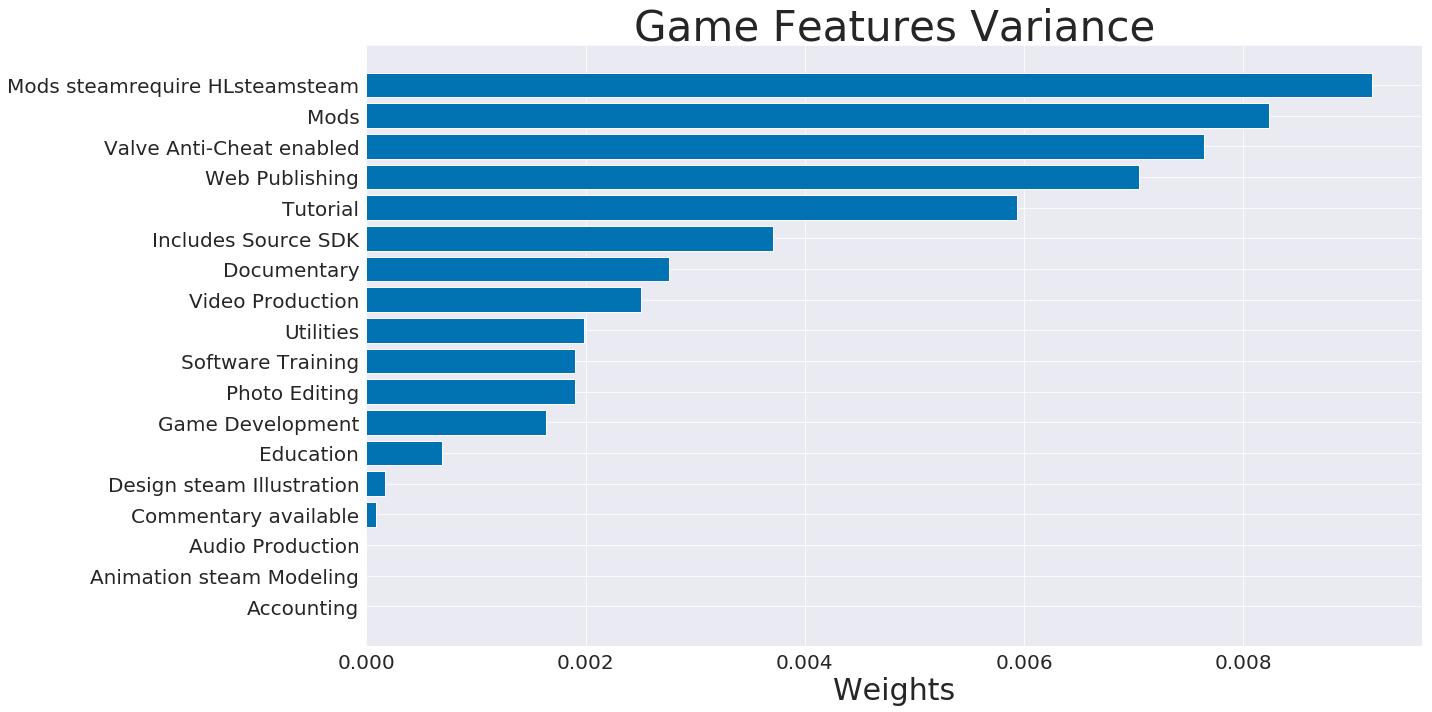

In [55]:
plt.figure(figsize=(20,10))
plt.barh(var, features_vars)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Weights', fontsize=30)
plt.title(f'Game Features Variance', fontsize=42)
plt.tight_layout();

The features presented above, are the features that has low variance among my DataFrame. Therefore, I will drop the features that are listed on here. If we interpret them, features like Audio Production, Mods, Photo Editing.. etc are not important when it comes to choosing a game. Therefore; dropping these features will increase the quality of our recommender. 

In [56]:
game_features.drop(var, axis=1, inplace=True)

Now, after performing feature selection from variance, regex and features that contain 'Steam' which remove most of the unwanted features. Now I will manually interpret each columns that's left and decide if one needs to be dropped

In [57]:
game_features.columns

Index(['Action', 'Adventure', 'Captions available', 'Casual', 'Co-op',
       'Cross-Platform Multiplayer', 'Early Access', 'Free to Play',
       'Full controller support', 'Gore', 'In-App Purchases',
       'Includes level editor', 'Indie', 'Local Co-op', 'Local Multi-Player',
       'MMO', 'Massively Multiplayer', 'Multi-player', 'Nudity',
       'Online Co-op', 'Online Multi-Player', 'Partial Controller Support',
       'RPG', 'Racing', 'Sexual Content', 'Shared/Split Screen', 'Simulation',
       'Single-player', 'Sports', 'Stats', 'Strategy', 'Violent',
       'VR Support'],
      dtype='object')

| Features | Description | Drops |
| --- | --- | :-: |
| Action | the player assumes the role of a protagonist in an interactive story driven by exploration and puzzle-solving | |
| Captions available | This will be dropoped, since captions availability isn't important in choosing games | Yes |
| Casual | They are typically distinguished by simple rules and by reduced demands on time and learned skill | |
| Co-op | that allows players to work together as teammates, usually against one or more AI opponents | |
| Cross-Platform Multiplayer | This will be dropped, since cross platform means you can play with players from different platform like PS4 and XBOX | Yes |
| Early Access | This will be dropped, Since early access isn't important for users that are looking for new games | Yes |
| Free to Play | Free to play game |
| Full controller support | This will be dropped, since Steam is used for PC gaming, controller support won't be the piority when looking for new game | Yes |
| Gore | This usually falls under the game that is involed in blood, devil, or violent |
| In-App Purchases | This will be dropped, since this won't be a good features in games | Yes |
| Includes level editor | This will be dropped, since level ito isn't the first option when searching for games | Yes |
| Indie | Indie also kown as Independent Video Game, These games often focus on innovation and rely on digital distribution |
| Local Co-op | This will be dropped, since we have a coop feature already | Yes |
| Local Multi-Player | This will be dropped, we have multiplayer feature already | Yes |
| MMO | Also known as Massive Multiplayer Online game, an online game with large numbers of players, typically from hundreds to thousands, on the same server |
| Massively Multiplayer | This will be dropped, we have MMO feature already | Yes |
| Multi-player | Although this is really similar to MMO, but some games isn't massive in terms of server |
| Nudity | scantily clad images or characters to sell or enhance games, some go further, using sex acts or nudity as a character motivation |
| Online Co-op | This will be dropped, we have coop feature already | Yes |
| Online Multi-Player | This will be dropped, we have MMO and Multiplayer feature already | Yes |
| Partial Controller Support | Similar to Fullcontrollersupport feature, we will drop this | Yes |
| RPG | Also known as Role Playing Game, where the player controls the actions of a character immersed in some well-defined world |
| Racing | player partakes in a racing competition with any type of land, water, air or space vehicles |
| Sexual Content | This is extreamly similar to the Nudity but this covers more than just nudity |
| Shared/Split Screen | Will be dropped, since shared screen is not the biggest reason player considered nowadays | Yes |
| Simulation | describes a diverse super-category of video games, generally designed to closely simulate real world activities. |
| Single-player | This will be dropped, because a lot of Multiplayer games has singleplayer campaign or mode | Yes |
| Sports | that simulates the practice of sports, including team sports, track and field, extreme sports and combat sports |
| Stats | Will be dropped, this means statistic from the game | Yes |
| Strategy | that focuses on skillful thinking and planning to achieve victory |
| Violent | Game that contain violent content |
| VR Support | is an interactive computer-generated experience taking place within a simulated environment |
| Valve Anti-Cheat enabled | Anit-Cheat System | Yes |





Seems like a lot of the features are really similar to each other. I am going to create a list of the similar features and combine them. This will increase the quality of my result as well.

In [58]:
mmo_list = ['Massively Multiplayer',
        'MMO'
]

In [59]:
multiplayer_list = ['Cross-Platform Multiplayer',
             'Local Multi-Player',
             'Online Multi-Player',
            'Shared/Split Screen',
            'Multi-player',
]

In [60]:
coop_list = ['Local Co-op',
             'Online Co-op',
             'Co-op'
]

MMO and Massively Multiplayer are extremely similar to each other. Therefore; I will combine these two features together.

In [61]:
game_features['MMO'] = game_features[mmo_list].sum(1) > 0

There are many `multi-player` categories in my features. I will combine them since they're extremely similar to each other.

In [62]:
game_features['Multi-player'] = game_features[multiplayer_list].sum(1) > 0

There were three Co-ops features in my DataFrame. They're all falling under Co-op category; therefore I will combine them.

In [63]:
game_features['Co-op'] = game_features[coop_list].sum(1) > 0

After combining the features. I will drop them, so there won't be any duplicates in my features.

In [64]:
drop_list = ['Captions available',
             'Cross-Platform Multiplayer',
             'Early Access',
             'Full controller support',
             'In-App Purchases',
             'Includes level editor',
             'Local Co-op',
             'Local Multi-Player',
             'Massively Multiplayer',
             'Online Co-op',
             'Online Multi-Player',
             'Partial Controller Support',
             'Shared/Split Screen',
             'Single-player',
             'Stats']

In [65]:
game_features.drop(drop_list, axis=1, inplace=True)

I will get a return of True and False on the features that I just combined. I will change that to Ture is 1.0 and False should be 0.0. 

In [70]:
game_features[['Co-op', 'MMO','Multi-player']] = game_features[['Co-op', 'MMO','Multi-player']].astype(float)


After filtering, we only have 18 unique features for 11,557 games. Therefore, I will include the game description as part of my features as well.

In [71]:
game_features.shape

(11557, 18)

In [72]:
game_features.head()

,Action,Adventure,Casual,Co-op,Free to Play,Gore,Indie,MMO,Multi-player,Nudity,RPG,Racing,Sexual Content,Simulation,Sports,Strategy,Violent,VR Support
game_id,,,,,,,,,,,,,,,,,,
10,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
game_features.to_csv('./datas/game_features.csv')

# EDA: Data Cleaning (game_description)
---

**In big picture:**

Since I am going to use the game description as part of my features from each game. I am going to clean up the text and perfrom a tozkenization followed by lemmatization to seperates the context into each individual words and use it as part of my features.

I will merge my game_lookup DataFrame and game_description together. This is to match up the game_id. Reason why is because after the filtering process from game_reviews and game_lookup, that eliminate a lot of games. To further filtering I will need to match the game_id on each DataFrame.  


In [74]:
game_description = pd.merge(game_description, game_features[['Action']], left_index=True, right_index=True)
game_description.drop('Action', axis=1, inplace=True)

In [75]:
game_description = game_description[~game_description.index.duplicated(keep=False)]

In [76]:
game_description.shape

(11557, 1)

**Regular Expression(Regex)**

I've used Regular Expression to remove the context that contained something like website links or html format context. So I only keeping the clean game description.

In [77]:
game_description['game_description'] = game_description.game_description.map(lambda x: re.sub('[0-9]', ' ',str(x)))

There are several unwanted text within my game_description; text like html and links. I will perform a Regex to clean out the unwanted text and format.

In [78]:
game_description['game_description'] = [re.sub('<\w+ \w+=\"[^\>]*>', ' ',
                                               re.sub('<[\w\s/]+>', ' ',
                                                      re.sub('\t', ' ',
                                                             re.sub('\n', ' ',
                                                                    re.sub('\r',  '', str(text)))))) for text in game_description.game_description]

In [79]:
game_description['game_description'] = [re.sub('[^A-Za-z-/: ]', ' ', str(text)) for text in game_description.game_description]

**tokenized:**


We instantiate tokenizer and define the search pattern using r'\w+ as our regular expression. We only want to search through words and omit digits and symbols since they cannot serve as keywords in our digital network campaign.

It separates the words in the context into a list of string so we can perform lemmatization.


In [80]:
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')


**lemmatized:** 

After the context has been tokenized, Then I apply it to lemmatization.

Lemmatization is a form of shortening words so I can combine similar forms of the same word. When I Lemmatize the context, I take words and attempt to return their lemma, or the base/dictionary form of a word.

In [81]:
game_description['tokenized'] = game_description['game_description'].apply(lambda x: tokenizer.tokenize(x))

I will create a new column in my DataFrame that named lemmatized and tokenized, then join them together. As demonstrated below you can see the process of what tokenized and lemmatization do to the game_description.

In [82]:
game_description['lemmatized']  = game_description['tokenized'].map(lambda x: ' '.join(lemmatizer.lemmatize(word) for word in x))

In [83]:
game_description.head()

,game_description,tokenized,lemmatized
game_id,,,
10,Play the world s number online action game ...,"[Play, the, world, s, number, online, action, ...",Play the world s number online action game Eng...
20,One of the most popular online action games of...,"[One, of, the, most, popular, online, action, ...",One of the most popular online action game of ...
30,Enlist in an intense brand of Axis vs Allied ...,"[Enlist, in, an, intense, brand, of, Axis, vs,...",Enlist in an intense brand of Axis v Allied te...
40,Enjoy fast-paced multiplayer gaming with Death...,"[Enjoy, fast, paced, multiplayer, gaming, with...",Enjoy fast paced multiplayer gaming with Death...
50,Return to the Black Mesa Research Facility as ...,"[Return, to, the, Black, Mesa, Research, Facil...",Return to the Black Mesa Research Facility a o...


**Stopwords and tfidf**

I added many additional stopwords into the default 'English'. This will exclude some basic English words like 'the, this, that, in, a....etc'. Reason why we do this is because I only want to include the important words that will be a good fit to represent as the game's feature.


Tfidf: This tells us which words are most discriminating between documents. Words that occur a lot in one document but doesn't occur in many documents will tell you something special about the document.
Tfidf relies on two stats: term frequency, and inverse document frequency

I manually removed the words because after several attempts of performing the model, words like "quot" "ii" "mode" "steam" "bb_tag" "new" "aaa" etc appears a lot. These words doesn't have any meaning into them. Also, because above words is irrelevant to my topic. Also, since I obtain my DataFrame from Steam therefore I will remove that. 

In [84]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(['quot',
    'ii', 
    'mode', 
    'steam', 
    'bb_tag', 
    'game', 
    'new', 
    'aaa', 
    'aa', 
    'nan', 
    'putt', 
    'ys', 
    'pac', 
    'nancy', 
    'lara', 
    'ea', 
    'pac', 
    'pug', 
    'gnu', 
    'jedi', 
    'lego', 
    'gpl', 
    'sonic', 
    'sam', 
    'jack', 
    'park', 
    'souls', 
    'worm', 
    'mar', 
    'nazi', 
    'batman', 
    'cry', 
    'sister', 
    'coaster', 
])

I will performed a Tfidf Vectorizer on my game_description, the stopwords will be the words that mentioned above along with the default English words. `min_df` and `max_df` 

 - min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. So words that mentioned 20 or more times will be included into my DataFrame; anything lower than that will be too little and will be dropped as well.
 - max_df: When building the vocabulary ignore terms that have a document frequency strictly higher than 95%. So if a word appears in my dataset for more than 95% it will be dropped. These words usually are the none default and was mentioned a lot. This words are most likely not useful.

In [85]:
tfidf = TfidfVectorizer(stop_words=stopwords, min_df=20, max_df=.95)

I fit my lemmatized words from my DataFrame into the tfidf vectorizer that I set above to perform the tfidf along with the threshold.

In [86]:
game_raw = tfidf.fit_transform(game_description['lemmatized'])

I am changing my game_tfidf DataFrame to Sparse data, reason being that Sparse data structures allow us to store only non-zero values assuming the rest of them are zeros. This approach saves a lot of memory and computing time. In fact, you can often encounter such matrices when working with NLP or machine learning tasks.

In [87]:
game_tfidf = pd.SparseDataFrame(game_raw, columns=tfidf.get_feature_names())

In [88]:
game_tfidf.head()

,abandon,abandoned,abducted,abilities,ability,able,aboard,abomination,abound,absolute,...,zany,zelda,zen,zero,zip,zombie,zombies,zone,zoo,zoom
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,0.116701,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


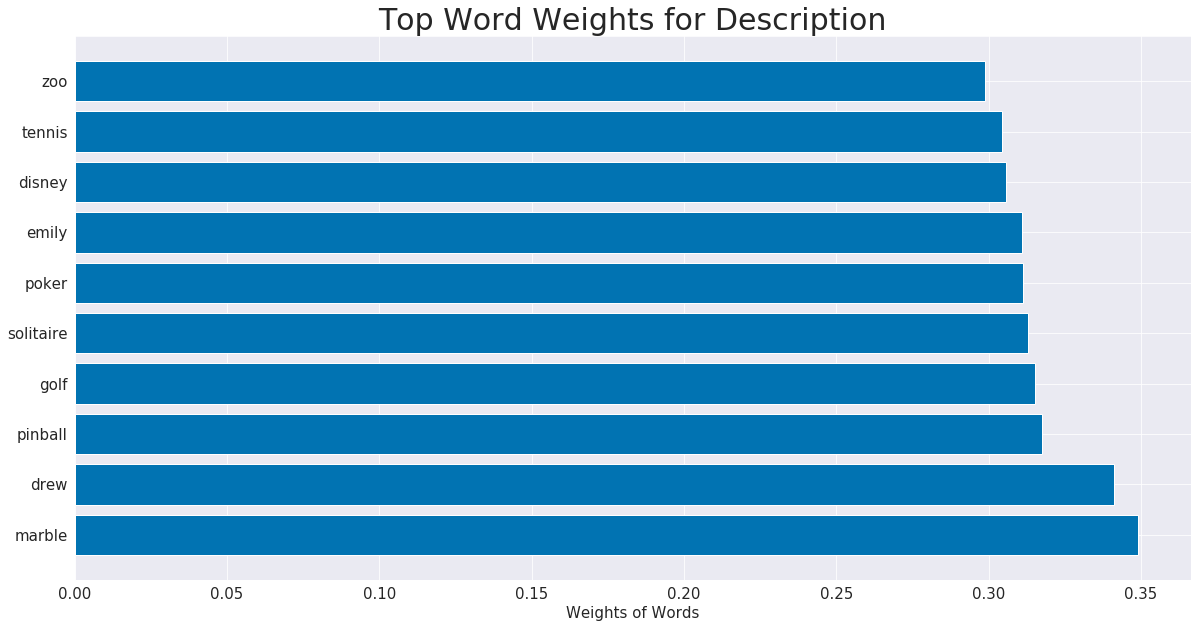

In [89]:
plt.figure(figsize=(20, 10))
plt.barh(y = game_tfidf.apply(lambda x: x.mean(), axis=0).sort_values(ascending=False)[:10].index,
         width = game_tfidf.apply(lambda x: x.mean(), axis=0).sort_values(ascending=False)[:10].values)
plt.title('Top Word Weights for Description', fontsize=30)
plt.xlabel('Weights of Words', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

Based on the graph below we can deduced that the top ten words that weighted the most among my game description data after performing Tfidf. I will go over the top five here to see if it's reasonable, if the word doesn't have any meaning in terms of determine my features, I will drop them.

After eliminating and adding the words that doesn't have meaning to stopwords. The three most weighted words are marble, drew and pinball. 
Marble, pinball, golf, and tennis are all in common. Whereas poker and solitaire are in commons as well.

This will match the index which is the game_id from game_description before I perform the tfidf. Since the position for the index is the same as game_description is the same. This will represent each game_id with the corresponding features after tfidf. 

In [90]:
game_tfidf.index = game_description.index

The NaNs here means that the game doesn't have that particular feature. Therefore, I will fill in 0 in all with all the NaN values. 

In [92]:
game_tfidf.fillna(0, inplace=True)

I will first convert my game_tfidf DataFrame `to_dense()` and become a `pandas.core.fram.DataFrame`, this will allow me to merge with game_features DataFrame. I then, will convert the game_final to a sparse data. Sparse objects are "compressed" when any data matching a specific value, this will increase the compute efficiency

In [93]:
game_tfidf = game_tfidf.to_dense()

game_final = pd.merge(game_tfidf, game_features,left_index=True,right_index=True)

game_final = game_final.to_sparse()

My game_final is the final DataFrame that will proceed to the next step. We have 11,557 unique games and 6,760 unique features into account. 

In [94]:
game_final.shape

(11557, 6760)

#### My game_final DataFrame is too huge to convert to `csv` directly, therefore, I converted my game_final to a` sparse.coo` matrix and save it as `npz` file. However; I will loose my columns and unique index, so I save columns and index to `csv`. 

In [95]:
game_final_coo = game_final.to_coo()
scipy.sparse.save_npz('./datas/game_final_coo.npz', game_final_coo)

In [96]:
cols = pd.DataFrame(game_final.columns)
cols.to_csv('./datas/game_final_cols.csv', header=False)

index = pd.DataFrame(game_final.index)
index.to_csv('./datas/game_final_insdex.csv', header=False)